# CS Project: Graph algorithm walkthrough

The main algorithm I have implemented is based on creating a graph to representing a piece of music.

As mentioned in the presentation, this algorithm can broken down into two stages: **indexing** and **querying**. For the graph-based algorithm, the **indexing** phase can be described as follows:

1. Split each piece into segments; each segment should represent a musical phrase as a listener would hear it
2. “Reduce” these segments, removing the least *relevant* notes.
3. Repeat step 2. until all segments contain only 1 note
4. Create a graph, with nodes being the segments, and edges representing reductions

## Setup

We will use the *music21* library to display the music, but the *mido* library is actually used within the algorithm to  read and analyse the music

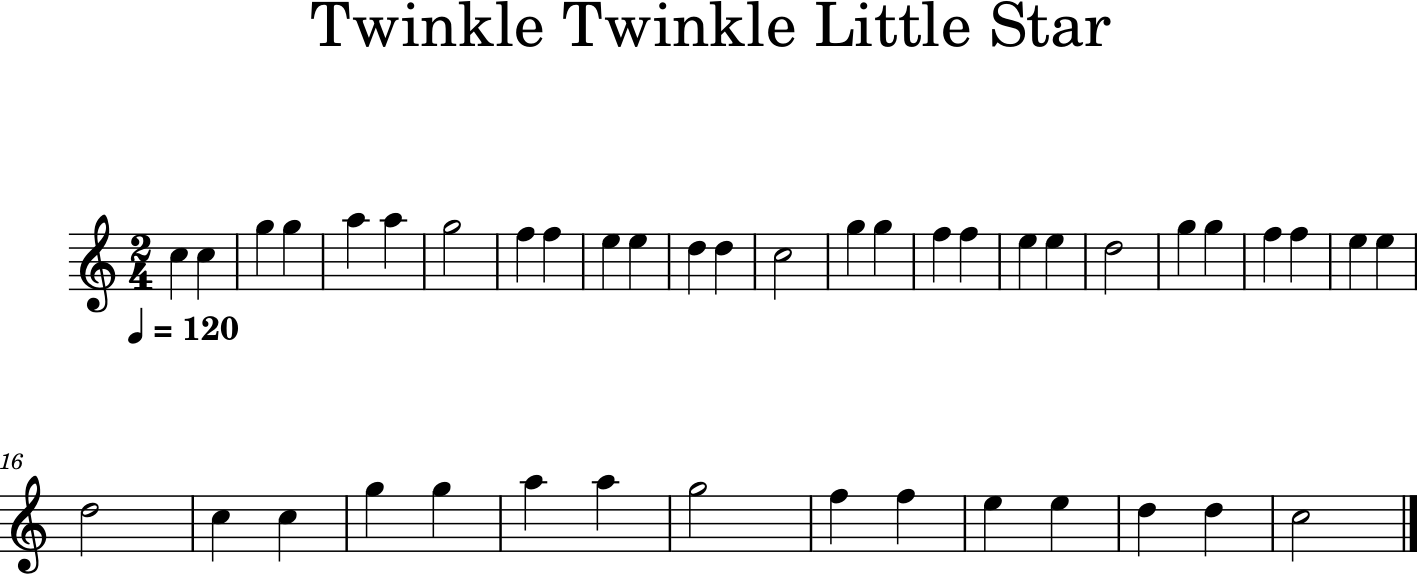

In [1]:
import music21 
%reload_ext music21.ipython21.ipExtension
import project.visualisation.graph as vis


show_mid = music21.converter.parse("mid/Twinkle_Twinkle_little_star.mid")
show_mid.insert(0, music21.metadata.Metadata())
show_mid.metadata.title = 'Twinkle Twinkle Little Star'
show_mid.show()

### Segmentation 

This is achieved through the **LBDM** algorithm. Given an input MIDI file, the LBDM produces a *boundary strength* profile. The idea is that boundaries (place where a listener would percieve a different musical phrase) occur at places in the music where the change in pitch and note length are significantly different to the boundaries around it.

### Example: Visualising LBDM as a graph

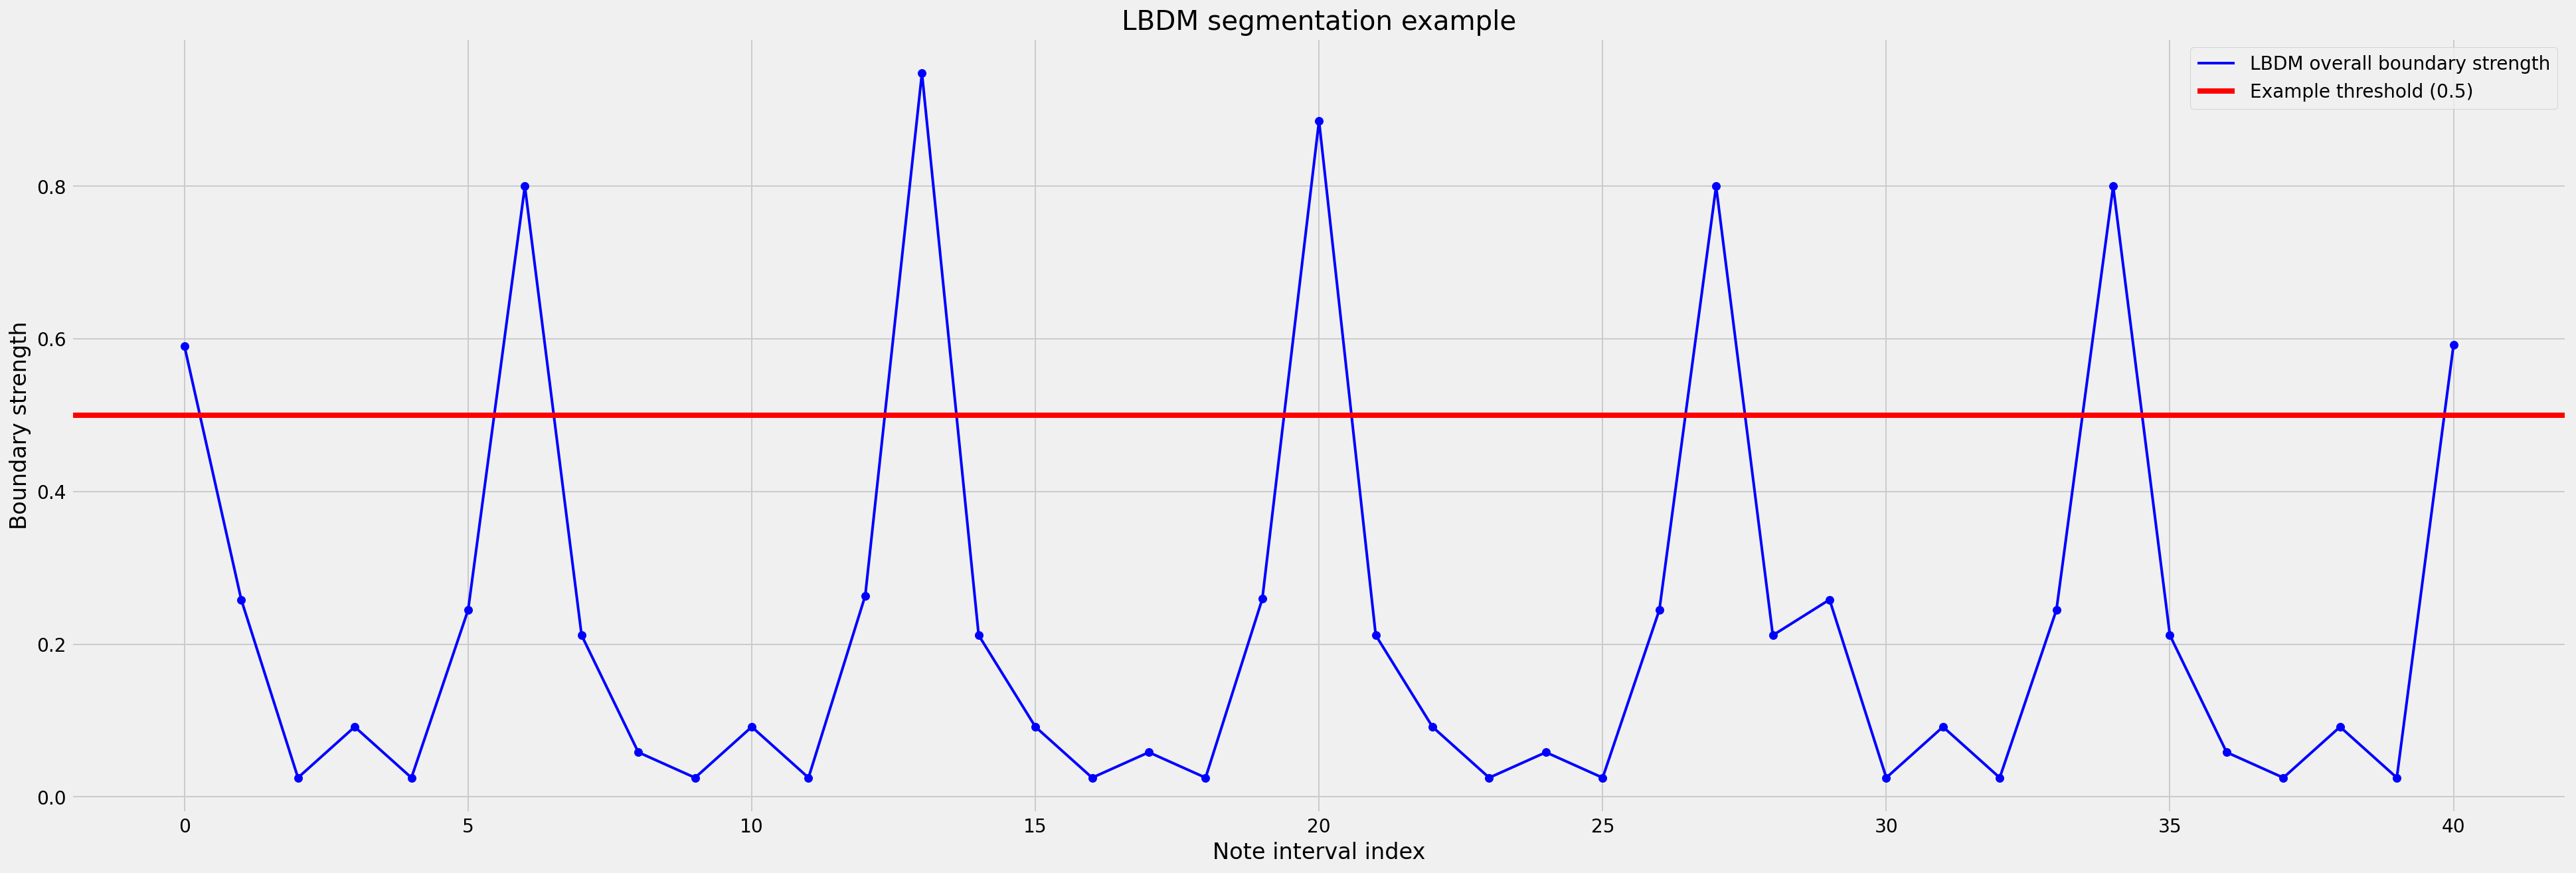

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from mido import MidiFile, MidiTrack 
example_mid = MidiFile("mid/Twinkle_Twinkle_little_star.mid")
melody_track = example_mid.tracks[0]

# formatting
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [30, 10]
vis.lbdm_graph(melody_track,example_mid.ticks_per_beat)

We can use this series of points to find boundaries in the music. The **segmenter** class creates segments from an input MIDI file. The **LbdmSegmenter** class does this by getting the boundary profile by running the LBDM algorithm, and then splitting the input file at points where the *boundary strength* is above a threshold (in this case 0.5, though we never include the first note)

In [3]:
from project.algorithms.graph_based.lbdm_segmenter import LbdmSegmenter

segmenter = LbdmSegmenter(threshold=0.5)
segments = segmenter.create_segments(example_mid,track_index=0)
for i, segment in enumerate(segments):
    segment.save_as_midi(f"mid/demo/ttwl_{i}.mid")

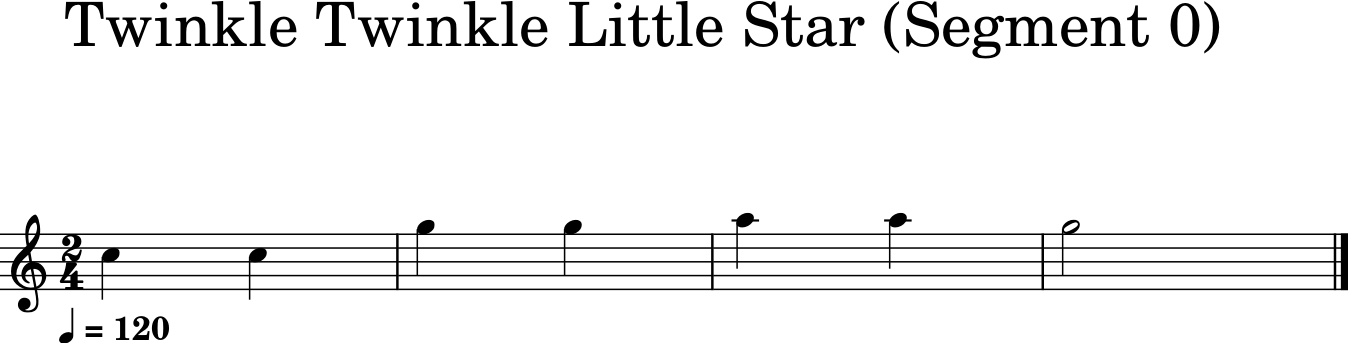

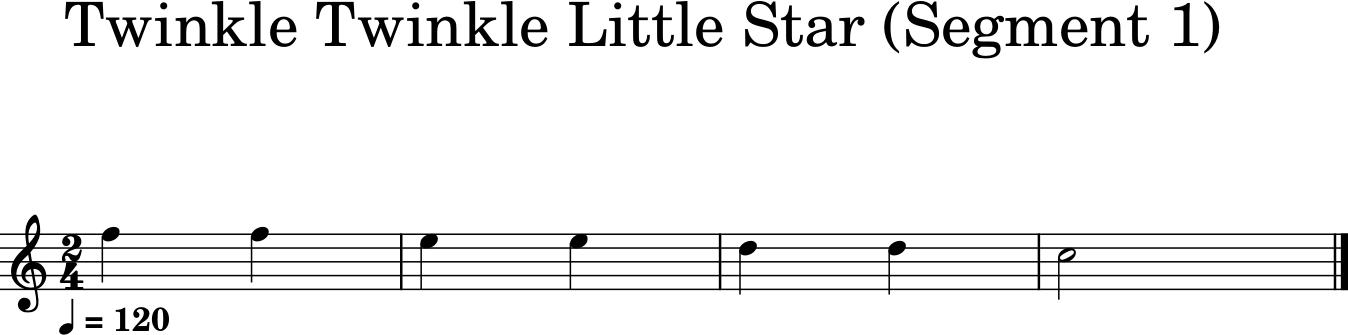

In [4]:
segment_mid_0 = music21.converter.parse(f"mid/demo/ttwl_0.mid")
segment_mid_0.insert(0, music21.metadata.Metadata())
segment_mid_0.metadata.title = 'Twinkle Twinkle Little Star (Segment 0)'
segment_mid_0.show()

segment_mid_1 = music21.converter.parse(f"mid/demo/ttwl_1.mid")
segment_mid_1.insert(0, music21.metadata.Metadata())
segment_mid_1.metadata.title = 'Twinkle Twinkle Little Star (Segment 1)'
segment_mid_1.show()
    

## Reduction

The next phase of the algorithm is *reduction*. This process simplifies each segment by deleting the least **relevant** notes from them. This process is repeated until each segment only has one note.

### Example

In [ ]:
ttwl_segment_0 = segments[0]

weight, ttwl_segment_0_reduced = ttwl_segment_0.reduce_segment()

ttwl_segment_0_reduced.save_as_midi("mid/demo/ttwl_reduction_1.mid")

red_mid = music21.converter.parse("mid/demo/ttwl_reduction_1.mid")
red_mid.insert(0, music21.metadata.Metadata())
red_mid.metadata.title = 'Twinkle Twinkle Little Star (Segment 0) (reduced)'

segment_mid_0.show()
red_mid.show()

As mentioned above, this process goes on until there's only one note left in the segment. Here's an example with a random segment:

In [ ]:
full_reduction = music21.converter.parse("mid/generated/graph/nottingham_graph_chord_combined/ashover13/combined_segment_0.mid")
full_reduction.show()

## Putting it altogether: a *graph* representation of the music

So to recap, we can split the music into several segments using LBDM, and then reduce these segments until they only consist of 1 note. From here we create a *graph* of the segments. When creating a graph in this *indexing* stage, this consists of just connecting each segment to it's reduction. This graph is weighted, with the weights being determined by what notes were deleted in the reduction phase

Using the `segment_graph` function, we can create a graph of Twinkle Twinkle little star:

In [ ]:
from project.algorithms.graph_based.segment_graph_based import segment_graph

segment_graph("mid/Twinkle_Twinkle_little_star.mid",melody_track=0,
              output_folder="demo",chord_track=None,save_combined=False)


The graph is saved as a `pickle` which is a binary format that python can write and read to very quickly. We can read it and display it:

In [ ]:
import pickle
import matplotlib.image as mpimg

graph_path = "mid/generated/graph/demo/Twinkle_Twinkle_little_star/graph.gpickle"
with open(graph_path,"rb") as handle:
    graph = pickle.load(handle)

graph.draw(path="example_output/demo_graph.png")
graph_img = mpimg.imread("example_output/demo_graph.png")

plt.rcParams["axes.grid"] = False
plt.imshow(graph_img)

## Querying
When querying the graph, we treat the query MIDI file as an entire segment and then compute its reductions. Then, for each reduced segment in the graph, we check whether the query segment reduced to the same thing at any point. If this is the case, we add a 0 cost edge between that segment and the query segment.

To determine *similarity* between a query and a music piece (represented as a graph), we take either the average, or minimum distance of the shortest path between the original segments and the non-reduced query segment. In the case there's no common reduction, we add a large penalty to the "distance" between the segments

In [ ]:
from project.algorithms.graph_based.query_graph_based import query_graph
with open("mid/generated/graph/nottingham_graph_nochords/ashover13/graph.gpickle","rb") as handle:
    graph_2 = pickle.load(handle)
rankings = query_graph(f"mid/demo/ttwl_0.mid", melody_track=0, use_minimum=False, write_graphs=True, graphs=[graph, graph_2])

In [ ]:
graph_img = mpimg.imread("example_output/twinkle_graph_example.png")

plt.rcParams["axes.grid"] = False
plt.imshow(graph_img)